WS 25/26
# WP5: Neural Computation

Thomas Wachtler  
*CNS, Faculty of Biology, LMU Munich*

## Exercise 4.5
### Analysis of Non-Linearities

---

---
## 1. The Gabor Filter Model ##

A model for the Simple Cell receptive field is the two-dimensional Gabor Filter,
which is constructed as the product of a sinewave grating with a two-dimensional Gaussian,

$$G(x,y) = \frac{1}{2 \pi \sigma_x \sigma_y} e^{-\frac{x^2}{2 \sigma_x^2}-\frac{y^2}{2 \sigma_y^2}} \cos(kx - \varphi)$$

where $k = \frac{2 \pi}{\lambda}$ is the spatial frequency, $\lambda$ the wavelength (period) of the cosine.

**a)**
The equation above describes a filter with orientation preference perpendicular to the x axis (i.e., vertical).
How would you change the equation to get a preferred orientation of 45 degrees?

**Answer:**
To get an equation of $45$ degrees, we rotate the axis, thus we get
$$
x \to \frac{x-y}{\sqrt{ 2 }}
$$ Thus, we have
$$
G(x,y) = \frac{1}{2 \pi \sigma_x \sigma_y} e^{-\frac{x^2}{2 \sigma_x^2}-\frac{y^2}{2 \sigma_y^2}} \cos(k \frac{x-y}{\sqrt{ 2 }}  - \varphi)
$$



### 1.1. One-dimensional Gabor ###

**b)**
We consider the one-dimensional case, i.e., let $y=0$, $\sigma_y=1$ in the above equation.

Plot $G(x)$ for different values of $\sigma_x$, $\lambda$, and $\varphi$ to understand the contribution
of these parameters to the filter structure.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

### 1.2. Two-dimensional Gabor ###

Now we consider the two-dimensional case, but to keep things simple we let $\sigma_x = \sigma_y = \sigma$.

**d)**
Plot the DoG filter that you used to filter the "munich.jpg" image in exercise 4.

Define four even-symmetrical Gabor filters with the properties described in **c)** and
spatial frequency such that the on-off structure approximately matches in size that of the DoG filter
and with four orientations (0, 45, 90, 135 degrees).

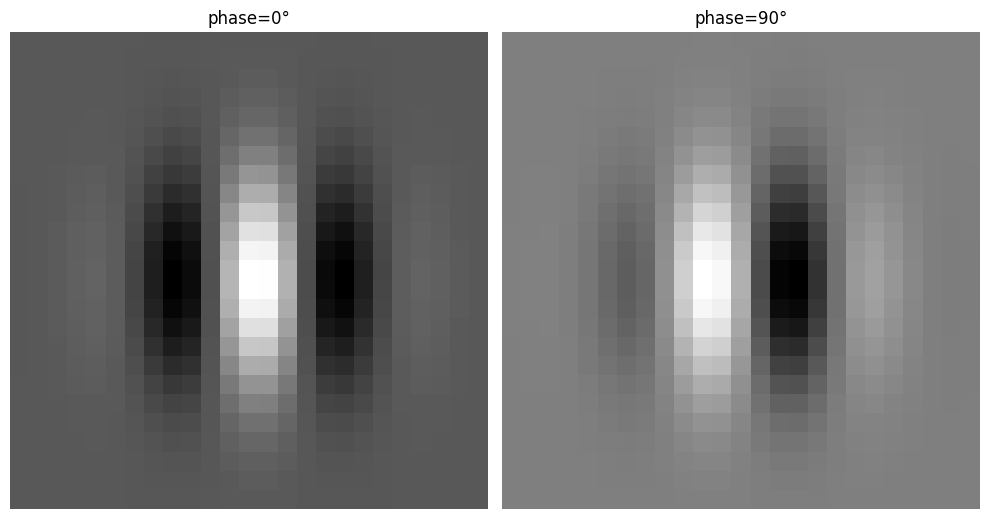

In [18]:
def G_2d(sigma_x, sigma_y, lambda_, phi, theta, size=100):
    """ 2D Gabor function

    Parameters
    ----------
    sigma_x : float
        Standard deviation of the Gaussian envelope in x direction.
    sigma_y : float
        Standard deviation of the Gaussian envelope in y direction.
    lambda_ : float
        Wavelength of the sinusoidal factor.
    phi : float
        Phase offset of the sinusoidal factor.
    theta : float
        Orientation of the Gabor function in radians.
    size : int
        Size of the output 2D array.

    Returns
    -------
    gabor_2d : array_like
        2D array representing the Gabor function.
    """
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)

    # Rotate coordinates
    X_theta = X * np.cos(theta) + Y * np.sin(theta)
    Y_theta = -X * np.sin(theta) + Y * np.cos(theta)

    gaussian_envelope = np.exp(-0.5 * ((X_theta**2 / sigma_x**2) + (Y_theta**2 / sigma_y**2)))
    sinusoidal_factor = np.cos(2 * np.pi * X_theta / lambda_ + phi)
    gabor_2d = gaussian_envelope * sinusoidal_factor
    return gabor_2d

# make 4 subplots for 4 theta values
phase_values = [0, np.pi/2]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes = axes.ravel()
for i, phase in enumerate(phase_values):
    gabor_2d = G_2d(4, 4, 10.0, phase, 0, size=25)
    axes[i].imshow(gabor_2d, cmap='gray')
    axes[i].set_title(f'phase={phase*180/np.pi:.0f}°')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [11]:
# =============================
# 1. GABOR FILTERS
# =============================
sigma_x = 4
sigma_y = 4
lambda_ = 10.0
size = 25

gabor_real = G_2d(sigma_x, sigma_y, lambda_, 0, 0, size)
gabor_imag = G_2d(sigma_x, sigma_y, lambda_, np.pi/2, 0, size)

# =============================
# 2. COMPLEX CELL RESPONSE
# =============================
def complex_cell_response(S, gr, gi):
    r1 = np.sum(S * gr)
    r2 = np.sum(S * gi)
    gain = 10
    return gain * (r1**2 + r2**2)    # nonlinear complex cell output

# =============================
# 3. FIND A THRESHOLD FOR SPIKES
# =============================
responses = []
num_for_threshold = 3000

for _ in range(num_for_threshold):
    S = np.random.randn(size, size)
    S -= S.mean()
    S /= S.std()

    responses.append(complex_cell_response(S, gabor_real, gabor_imag))

threshold = np.percentile(responses, 95)  # only the top 5% will spike
print("Spike threshold =", threshold)


Spike threshold = 1375.0149979396836


In [12]:

# =============================
# 4. SIMULATE STIMULI
# =============================
N_stim = 30000     # number of random images
STE = []           # spike-triggered ensemble

for _ in range(N_stim):
    S = np.random.randn(size, size)
    S -= S.mean()
    S /= S.std()
    resp = complex_cell_response(S, gabor_real, gabor_imag)
    
    if resp > threshold:
        STE.append(S.reshape(-1))    # flatten to vector

STE = np.array(STE)
print("Spike count =", STE.shape[0])


Spike count = 1532


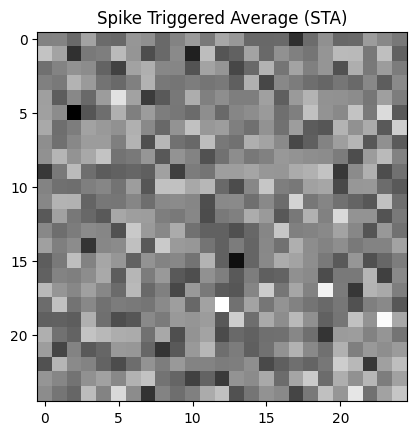

In [13]:

# =============================
# 5. COMPUTE STA
# =============================
STA = np.mean(STE, axis=0)
STA_img = STA.reshape(size, size)

plt.imshow(STA_img, cmap='gray')
plt.title("Spike Triggered Average (STA)")
plt.show()


In [6]:
# Normal Eigenvalues are slow
# # =============================
# # 6. Spike-Triggered Covariance
# # =============================
# STE_centered = STE - STA

# C = np.cov(STE_centered, rowvar=False)   # 10k × 10k covariance

# # Eigen-decomposition
# vals, vecs = np.linalg.eigh(C)

# # Take top eigenvectors (largest + smallest)
# idx_sorted = np.argsort(vals)[::-1]   # descending
# e1 = vecs[:, idx_sorted[0]].reshape(size, size)
# e2 = vecs[:, idx_sorted[1]].reshape(size, size)

# # =============================
# # 7. PLOT STC COMPONENTS
# # =============================
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(e1, cmap='gray')
# plt.title("STC Component 1")

# plt.subplot(1, 2, 2)
# plt.imshow(e2, cmap='gray')
# plt.title("STC Component 2")

# plt.show()


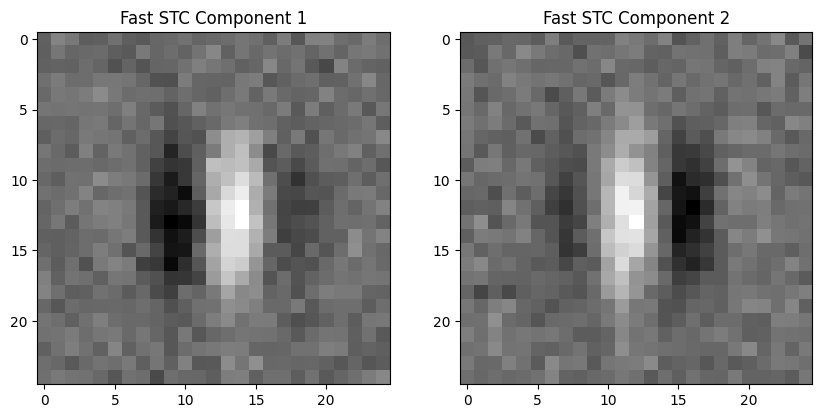

In [17]:
# X = STE_centered
X = STE - STA     # shape: (Ns, 10000)
Ns = X.shape[0]

from sklearn.utils.extmath import randomized_svd 

# ----- 6. Fast STC via randomized SVD -----
U, S, Vt = randomized_svd(X, n_components=10)

eigenvalues = S**2 / (X.shape[0] - 1)

# ----- 7. Take smallest eigenvectors -----
ix = np.argsort(eigenvalues)

e1 = Vt[ix[-1]].reshape(size, size)
e2 = Vt[ix[-2]].reshape(size, size)

# --------- PLOT ----------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(e1, cmap='gray')
plt.title("Fast STC Component 1")

plt.subplot(1, 2, 2)
plt.imshow(e2, cmap='gray')
plt.title("Fast STC Component 2")

plt.show()
